# **Exploring and Classifying Fraudulent Fraudulent Transactions**


# Project Overview

In this project, I analyze financial transaction data to explore patterns of fraudulent behaviour. Areas that I explore are:
- time of transaction
- payment type
- amount of transaction
- account type
- account balance
- flagged transaction

Once I obtain a set of features that correlate with fraudulent data, I train the machine learning models RandomForest and ExtremeGradientBoost to classify and predict whether a transaction is fraudulent or not. 

I then evaluate the classifications of these models and choose the better algorithm. 

# Dataset

The dataset used for this project is called [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/datasets/ealaxi/paysim1?page=2) from Kaggle. 

The dataset is a synthetic dataset generated based on real mobile money transactions extracted from one month of financial logs from a mobile money service implemented in an African country. This dataset was generated specifically for fraud detection research. 

The dataset contains 6362620 rows and 11 variables. The variables are listed below followed by a brief description.

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



## Loading Python Packages and Dataset

In [1]:
# Loading Python Packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Loading data 
data = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

## Exploratory Data Analysis

### 1. Data Overview and Summary Statistics

In [3]:
# View first 5 rows of data 
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# View last 5 rows of data
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [5]:
# View summary statistics
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
# View data type 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Find any null entries
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
# Find duplicate entries 
data.duplicated().sum()

0

#### Insights
1. There are no null values and duplicate rows - no imputation necessary
2. There are over 6 million transaction details
3. There are 11 variables
4. There are instances where there is a 'TRANSFER' followed by 'CASH_OUT', both for the same amount, and both transactions are flagged as fraud (observed in the first 5 rows and last 5 rows)
5. From the first 5 rows and last 5 rows, all transactions with newbalanceOrig = 0 are Fraudulent transactions
6. From the last 5 rows, no transactions that were "TRANSFER" with amount > 200,000 currency units were Flagged as Fraud. The flagging system may not be effective

### 2. Exploring Time of Transaction

In [9]:
# Create a new dataset to add changes to
data_ml = data.copy() 

# Create subsets of fraud and valid transactions
valid = data_ml[data_ml['isFraud'] == 0]
fraud = data_ml[data_ml['isFraud'] == 1]


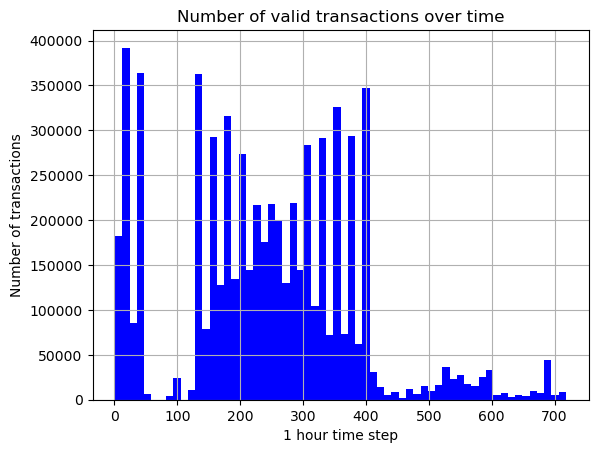

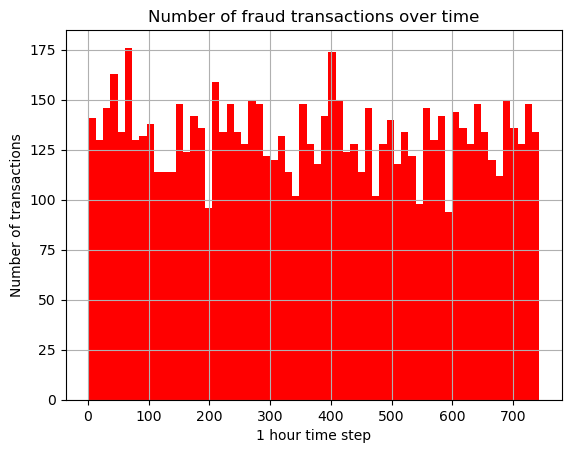

In [10]:
# Visualize Valid and Fraud transactions over time
bins = 62 #each bin correspond to 12 steps/hours

valid.hist(column = "step", color="blue", bins = bins)
plt.xlabel("1 hour time step")
plt.ylabel("Number of transactions")
plt.title("Number of valid transactions over time")

fraud.hist(column = "step", color="red", bins = bins)
plt.xlabel("1 hour time step")
plt.ylabel("Number of transactions")
plt.title("Number of fraud transactions over time")

plt.show()

#### Insights
1. Valid transactions do not occur consistently over time. There are spikes throughout certain periods. A significant porportion of transactions occur during timesteps 0-48 and 120-408. Within these timesteps, the transaction volume also alternate between high and low per 12 hour bins. 
2. Fraud transactions occur uniformly over time with little variation.

It's interesting that the transaction volume of valid transactions alternate between high and low per 12 hours duration. To dig deeper, I will explore timesteps by hour of the day.

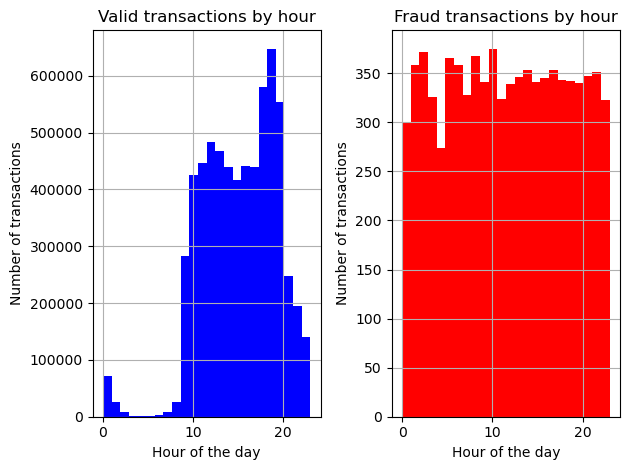

In [11]:
# Visualize Valid and Fraud transactions by hour of the day
# Timesteps by hour of day 
valid_hours = valid.step % 24 
fraud_hours = fraud.step % 24 

plt.subplot(1, 2, 1)
valid_hours.hist(bins = 24, color = "blue")
plt.title('Valid transactions by hour')
plt.xlabel('Hour of the day')
plt.ylabel("Number of transactions")

plt.subplot(1, 2, 2)
fraud_hours.hist(bins = 24, color = "red")
plt.title('Fraud transactions by hour')
plt.xlabel('Hour of the day')
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()

#### Insights

1. There is a distinct period of time for when valid transactions occur less during the day, which is from Hour0 to Hour9. 
2. Fraud transactions occur uniformly over hours of the day with little variation. 

'HourOfDay' is an important feature to add to detect fraudulent transactions. 

In [12]:
# Add new feature HourOfDay
data_ml['HourOfDay'] = data.step % 24

# View changes
data_ml.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,HourOfDay
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


### 3. Exploring Transaction Type

In [13]:
# Valid transactions by type
print("Valid transactions by type: \n",valid.type.value_counts())

# Fraud transactions by type 
print(" \n Fraud transactions by type: \n",fraud.type.value_counts())

Valid transactions by type: 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64
 
 Fraud transactions by type: 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


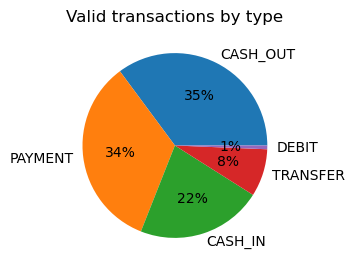

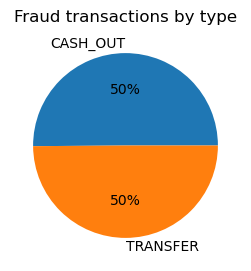

In [14]:
# Visualisation of transactions by type
valid_type = valid['type'].value_counts()
valid_transaction = valid_type.index
valid_count = valid_type.values

fraud_type = fraud['type'].value_counts()
fraud_transaction = fraud_type.index
fraud_count = fraud_type.values

plt.figure(figsize=(4,3))
plt.pie(valid_count, labels= valid_transaction, autopct='%1.0f%%')
plt.title("Valid transactions by type")
plt.show()

plt.figure(figsize=(4,3))
plt.pie(fraud_count, labels= fraud_transaction, autopct='%1.0f%%')
plt.title("Fraud transactions by type")
plt.show()

#### Insights
1. There are 5 types of transactions found in valid transactions. Most common transaction type is CASH_OUT, followed by PAYMENT, CASH_IN, TRANSFER and DEBIT. 
2. Fraud transactions ONLY occur with CASH_OUT and TRANSFER equally at 50% each. 

'type' is a necessary feature to keep to detect fraudulent transactions. 

### 4. Exploring Amount of Transaction

Valid transactions by amount: 
 count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64
 
 Fraud transactions by amount: 
 count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64


Text(0.5, 1.0, 'Valid and Fraud Transaction Amounts')

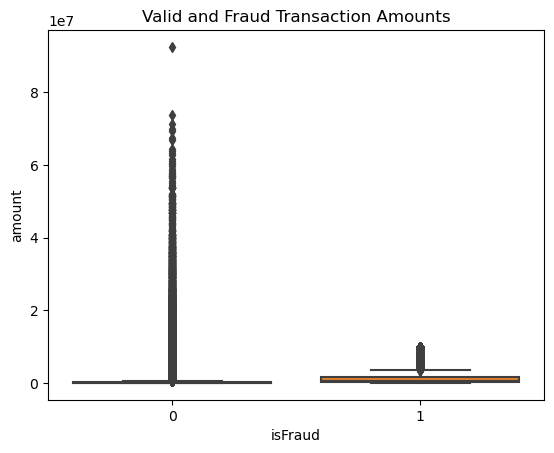

In [15]:
# View summary statistic of valid and fraud transaction amounts
print("Valid transactions by amount: \n", valid['amount'].describe())
print(" \n Fraud transactions by amount: \n", fraud['amount'].describe())

# Visualise summary statistics with boxplot
sns.boxplot(x = 'isFraud', y = 'amount', data = data_ml)
plt.title('Valid and Fraud Transaction Amounts')

#### Insights
1. Average transaction amount is higher in fraud transactions than in valid transactions
2. Fraud transactions are capped at 10,000,000 units currency whereas there appears to be no cap for valid transactions. 

'amount' is a necessary feature to keep to detect fraudulent transactions.

### Exploring Account Type
In nameOrig and nameDest, referring to the name of the initiator and the name of recipient of the transaction, the first character is denoted with either "C" or "M". "C" corresponds to Customer and "M" corresponds to Merchant. 

I will create a new column 'fromto' classifying the account types involved in each transaction and explore whether certain account types are more likely to be fraudulent. 



In [16]:
data_ml["fromto"] = np.nan #create new column 

# filling feature column
data_ml.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"fromto"] = "CC" 
data_ml.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('M'),"fromto"] = "CM"
data_ml.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('C'),"fromto"] = "MC"
data_ml.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('M'),"fromto"] = "MM"


In [17]:
# Update fraud and valid subsets
valid = data_ml[data_ml['isFraud'] == 0]
fraud = data_ml[data_ml['isFraud'] == 1]

# Explore valid and fraud transactions by fromto accounts
print("valid transactions by fromto \n", valid.fromto.value_counts())
print("\n fraud transactions by fromto \n", fraud.fromto.value_counts())

valid transactions by fromto 
 CC    4202912
CM    2151495
Name: fromto, dtype: int64

 fraud transactions by fromto 
 CC    8213
Name: fromto, dtype: int64


#### Insights 

1. Valid transactions occur with CC and CM, Customer to Customer and Customer to Merchant.
2. Fraud transactions only occur with CC, Customer to Customer. 
3. No transactions are ever initiated by a Merchant. There are no MC or MM transactions.

fromto is an important feature to add to detect fraudalent transactions.

### 5. Exploring Account Balance

There are 4 columns relating to account balance: oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest.
I will not compare summary statistics of valid vs fraud transactions for all four. That is simply too much. 

However, when viewing the first 5 rows and last 5 rows of the dataset, I noticed that all transactions where newbalanceOrig = 0 were all fraudulent. I will check if this is coincidental or consistent for the rest of the data.

valid transactions by newbalanceOrig 
 count    6.354407e+06
mean     8.559702e+05
std      2.924987e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.447307e+05
max      4.368662e+07
Name: newbalanceOrig, dtype: float64

 fraud transactions by newbalanceOrig 
 count    8.213000e+03
mean     1.923926e+05
std      1.965666e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.958504e+07
Name: newbalanceOrig, dtype: float64


Text(0.5, 1.0, 'Valid and Fraud newbalanceOrig')

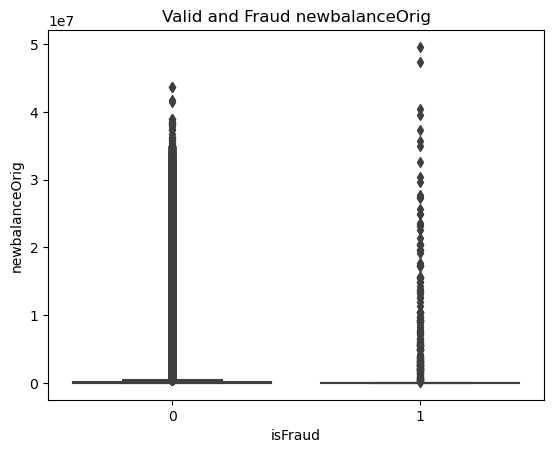

In [18]:
print("valid transactions by newbalanceOrig \n", valid.newbalanceOrig.describe())
print("\n fraud transactions by newbalanceOrig \n", fraud.newbalanceOrig.describe())

sns.boxplot(x = 'isFraud', y = 'newbalanceOrig', data = data_ml)
plt.title('Valid and Fraud newbalanceOrig')


#### Insight

A larger proportion of fraud transactions have newbalanceOrig = 0. However, valid transactions do also have newbalanceOrig = 0. It was only **coincidental** that only fraud transactions appeared in the first 5 and last 5 rows where newbalanceOrig = 0. 

From earlier observation, some transactions appear to have errors where newbalance don't match with oldbalance and amount transferred. I will check for the percentage of transactions with balance errors. 

In [19]:
# Find percentage of transactions with balance errors
wrong_orig_bal = sum(data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"])
wrong_dest_bal = sum(data["oldbalanceDest"] + data["amount"] != data["newbalanceDest"])

print("Percentage of transactions with balance errors in initiating account: ", 100*round(wrong_orig_bal/len(data),2))
print("Percentage of transactions with balance errors in the recipient account: ", 100*round(wrong_dest_bal/len(data),2))

Percentage of transactions with balance errors in initiating account:  85.0
Percentage of transactions with balance errors in the recipient account:  74.0


#### Insight

85% of transactions have balance errors in intiating account while 74% of transactions have balance errors in recipient account. 

Since we do not the reason why/how these errors occur, we do not know how to treat them.

One important note is that, if these errors are consistent and there is a pattern in valid transaction and fraud transactions, it is worth keeping the data to identify fraudulent transactions. Let's dig deeper to uncover any potential patterns.

In [20]:
# Create new column to denote error balance amounts
data_ml["errorBalanceOrig"] = data_ml.oldbalanceOrg - data_ml.newbalanceOrig - data_ml.amount
data_ml["errorBalanceDest"] = data_ml.newbalanceDest - data_ml.oldbalanceDest - data_ml.amount

# Update valid and fraud subset
valid = data_ml[data_ml['isFraud'] == 0]
fraud = data_ml[data_ml['isFraud'] == 1]

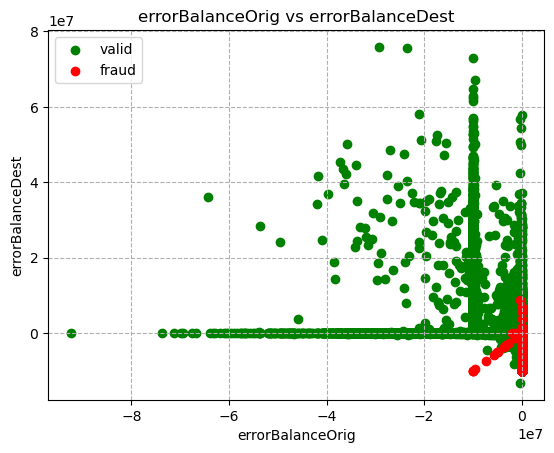

In [21]:
# Create scatterplot to visualise errorBalanceOrig and errorBalanceDest between valid and fraud transactions
plt.scatter(x = valid['errorBalanceOrig'],y = valid['errorBalanceDest'], c='green', label= 'valid')
plt.scatter(x = fraud['errorBalanceOrig'],y = fraud['errorBalanceDest'], c='red', label= 'fraud')
plt.legend(loc='upper left')
plt.title("errorBalanceOrig vs errorBalanceDest")
plt.xlabel('errorBalanceOrig')
plt.ylabel("errorBalanceDest")
plt.grid(linestyle = '--')
plt.show()

#### Insights

1. A large proportion of Valid transactions have 0 errorBalanceDest, 0 errorBalanceOrig, or -1e7 errorBalanceOrig. 
2. A majority of Fraud transactions have 0 errorBalanceOrig with +/- 1e7 errorBalanceDest. 

There are distinguishable differences between valid and fraud transactions in terms of errorbalance.

'errorBalanceOrig' and 'errorBalanceDest' are both necessary features to include to detect fraudulent transactions. 

### 6. Exploring Flagged Transactions

In [22]:
# How many transactions were flagged as fraud? 
flagged = data_ml[data_ml["isFlaggedFraud"] == 1] 
n_flagged = data_ml.isFlaggedFraud.sum()
print(" Number of transactions flagged:", n_flagged)

# How many transactions should have been flagged (fit the criteria of "TRANSFER" type and 
# amount > 200,000 units)
illegal = data_ml[(data_ml["amount"] > 200000) & (data_ml["type"] == 'TRANSFER')]
print("Number of transactions that should've been flagged:", len(illegal))

# Do flagged transactions fit the criteria to be flagged?
flagged_correctly = flagged[(flagged["amount"] > 200000) & (flagged["type"] == 'TRANSFER')]
print(len(flagged_correctly), "transactions out of", n_flagged, "transactions were flagged correctly according to criteria")

# How many flagged transactions were actually fraud?
print("Number of transactions flagged and was fraud:",flagged.isFraud.sum())

 Number of transactions flagged: 16
Number of transactions that should've been flagged: 409110
16 transactions out of 16 transactions were flagged correctly according to criteria
Number of transactions flagged and was fraud: 16


#### Insights
1. 409110 transactions fit the criteria of being an illegal attempt to transfer money, however only 16 of these transactions were flagged by the model.
2. Out of the 16 flagged transactions, all 16 were identified as fraudulent. 

'isFlaggedFraud' is a criteria based off two other columns in the dataset, however it does not function properly as most transactions that fit the criteria are not flagged. Additionally, since the criteria is based off other columns in the dataset and does not reveal significant information regarding fraudulent transactions, 'isFlaggedFraud' will not be included as a feature. 

## Preprocessing Data 

### 1. Dropping unused feature/columns

In [23]:
# View our current table
data_ml.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,HourOfDay,fromto,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,CM,1.455192e-11,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,CM,-1.136868e-12,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,CC,0.000000e+00,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,CC,0.000000e+00,-21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,CM,0.000000e+00,-11668.14


In [24]:
# Drop columns
data_ml = data_ml.drop(['step', 'nameOrig', 'nameDest', 'newbalanceOrig', 'newbalanceDest',
                        'isFlaggedFraud'], axis =1)

### 2. Encoding Categorical Variables

In [25]:
# View our current table
data_ml.head()

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,HourOfDay,fromto,errorBalanceOrig,errorBalanceDest
0,PAYMENT,9839.64,170136.0,0.0,0,1,CM,1.455192e-11,-9839.64
1,PAYMENT,1864.28,21249.0,0.0,0,1,CM,-1.136868e-12,-1864.28
2,TRANSFER,181.00,181.0,0.0,1,1,CC,0.000000e+00,-181.00
3,CASH_OUT,181.00,181.0,21182.0,1,1,CC,0.000000e+00,-21363.00
4,PAYMENT,11668.14,41554.0,0.0,0,1,CM,0.000000e+00,-11668.14


In [26]:
# One Hot Encode categorical  variables
data_ml = pd.get_dummies(data_ml)
data_ml

,amount,oldbalanceOrg,oldbalanceDest,isFraud,HourOfDay,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,fromto_CC,fromto_CM
0,9839.64,170136.00,0.00,0,1,1.455192e-11,-9.839640e+03,0,0,0,1,0,0,1
1,1864.28,21249.00,0.00,0,1,-1.136868e-12,-1.864280e+03,0,0,0,1,0,0,1
2,181.00,181.00,0.00,1,1,0.000000e+00,-1.810000e+02,0,0,0,0,1,1,0
3,181.00,181.00,21182.00,1,1,0.000000e+00,-2.136300e+04,0,1,0,0,0,1,0
4,11668.14,41554.00,0.00,0,1,0.000000e+00,-1.166814e+04,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,1,23,0.000000e+00,0.000000e+00,0,1,0,0,0,1,0
6362616,6311409.28,6311409.28,0.00,1,23,0.000000e+00,-6.311409e+06,0,0,0,0,1,1,0
6362617,6311409.28,6311409.28,68488.84,1,23,0.000000e+00,-1.000000e-02,0,1,0,0,0,1,0
6362618,850002.52,850002.52,0.00,1,23,0.000000e+00,-8.500025e+05,0,0,0,0,1,1,0


In [27]:
# Drop encoded columns to reduce multicollinearity
data_ml = data_ml.drop(['type_CASH_IN', 'type_DEBIT', 'type_PAYMENT', 'fromto_CM'], axis =1)
data_ml

,amount,oldbalanceOrg,oldbalanceDest,isFraud,HourOfDay,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_TRANSFER,fromto_CC
0,9839.64,170136.00,0.00,0,1,1.455192e-11,-9.839640e+03,0,0,0
1,1864.28,21249.00,0.00,0,1,-1.136868e-12,-1.864280e+03,0,0,0
2,181.00,181.00,0.00,1,1,0.000000e+00,-1.810000e+02,0,1,1
3,181.00,181.00,21182.00,1,1,0.000000e+00,-2.136300e+04,1,0,1
4,11668.14,41554.00,0.00,0,1,0.000000e+00,-1.166814e+04,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,1,23,0.000000e+00,0.000000e+00,1,0,1
6362616,6311409.28,6311409.28,0.00,1,23,0.000000e+00,-6.311409e+06,0,1,1
6362617,6311409.28,6311409.28,68488.84,1,23,0.000000e+00,-1.000000e-02,1,0,1
6362618,850002.52,850002.52,0.00,1,23,0.000000e+00,-8.500025e+05,0,1,1


### 3. Splitting and Standardizing Data

In [28]:
# Setting up target and feature variables
x = data_ml.drop(["isFraud"], axis = 1)
y = data_ml.isFraud
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8,random_state=0)

# Standardizing data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Model Selection

### 1. RandomForestClassifier

Random Forest Classifier is a supervised machine learning algorithm that builds decision trees on different samples and chooses the majority result for classification. 

As our dataset is imbalanced, I assign class_weight as 'balanced' to reduce bias of the majority class that is valid transactions. 

In [29]:
# Initiate model 
RFC = RandomForestClassifier(n_estimators = 25, class_weight = 'balanced', random_state=0)

# Fit the model
RFC_fit = RFC.fit(x_train, y_train)

# Predict the test set 
RFC_pred = RFC.predict(x_test)

# Evaluating model
CM_RFC = confusion_matrix(y_test,RFC_pred)
CR_RFC = classification_report(y_test,RFC_pred)
fprRFC, recallRFC, thresholdsRFC = roc_curve(y_test, RFC_pred)
AUC_RFC = auc(fprRFC, recallRFC)

resultsRFC = {"Confusion Matrix":CM_RFC,"Classification Report":CR_RFC,"Area Under Curve":AUC_RFC}

for measure in resultsRFC:
    print(measure,": \n",resultsRFC[measure])

Confusion Matrix : 
 [[1270848      35]
 [    296    1345]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.97      0.82      0.89      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524

Area Under Curve : 
 0.9097973208446473


### 2. ExtremeGradientBoosting
XGB is an algorithm that trains a number of decision trees and pools the results to generate the final prediction. XGB is a sequential model, meaning each subsequent tree is dependent outcome of the previous tree, as opposed to Random Forest where trees are built in parallel. 

For XGB, I train 2 models: one without scaling the weight and one with scaling to reduce bias on majority class.

In [30]:
# Initiate model 
XGB = XGBClassifier(random_state=0)

# Fit the model
XGB_fit = XGB.fit(x_train, y_train)

# Predict the test set 
XGB_pred = XGB.predict(x_test)

# Evaluating model
CM_XGB = confusion_matrix(y_test,XGB_pred)
CR_XGB = classification_report(y_test,XGB_pred)
fprXGB, recallXGB, thresholdsXGB = roc_curve(y_test, XGB_pred)
AUC_XGB = auc(fprXGB, recallXGB)

resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}

for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure])

Confusion Matrix : 
 [[1270854      29]
 [    240    1401]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.98      0.85      0.91      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.93      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524

Area Under Curve : 
 0.9268624480138578


In [31]:
# Initiate model 
XGB2 = XGBClassifier(random_state=0, scale_pos_weight=(y == 0).sum()/(y == 1).sum())

# Fit the model
XGB2_fit = XGB2.fit(x_train, y_train)

# Predict the test set 
XGB2_pred = XGB2.predict(x_test)

# Evaluating model
CM_XGB2 = confusion_matrix(y_test,XGB2_pred)
CR_XGB2 = classification_report(y_test,XGB2_pred)
fprXGB2, recallXGB2, thresholdsXGB2 = roc_curve(y_test, XGB2_pred)
AUC_XGB2 = auc(fprXGB2, recallXGB2)

resultsXGB2 = {"Confusion Matrix":CM_XGB2,"Classification Report":CR_XGB2,"Area Under Curve":AUC_XGB2}

for measure in resultsXGB2:
    print(measure,": \n",resultsXGB2[measure])

Confusion Matrix : 
 [[1269416    1467]
 [      7    1634]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.53      1.00      0.69      1641

    accuracy                           1.00   1272524
   macro avg       0.76      1.00      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524

Area Under Curve : 
 0.9972899964028762


### 3. Model Evaluation

In [32]:
# Print results of all models 
for measure in resultsRFC:
    print(measure,": \n",resultsRFC[measure], "\n")
    
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure], "\n")
    
for measure in resultsXGB2:
    print(measure,": \n",resultsXGB2[measure], "\n")

Confusion Matrix : 
 [[1270848      35]
 [    296    1345]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.97      0.82      0.89      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524
 

Area Under Curve : 
 0.9097973208446473 

Confusion Matrix : 
 [[1270854      29]
 [    240    1401]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.98      0.85      0.91      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.93      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524
 

Area Under Curve : 
 0.9268624480138578 

Confusion Matrix : 
 [[1269416    1467]
 [      7    1634]] 

Classification Repor

Comparing the RandomForestClassier algorithm and the first ExtremeGradientBoosting model, it can be observed that the ExtremeGradientBoosting model performs better on all evaluation metrics. 

Based on the Confusion Matrix, XGB obtained more True Positive, True Negatives and less False Positives and False Negatives. In turn, this translates to greater Precision and Recall scores, as well as AUC score. 

Taking a look at the second XGB model with scaled weight to account for imbalanced dataset, this model performs better on the Recall metric but worse on Precision metric. 

This means that XGB2 performs better at classifying fraud transactions as fraud transactions. There 1641 fraud transactions in the test set, and XGB2 correctly classifies 1634 transactions as fraud whereas XGB only correctly classifies 1401 as fraud (difference of 233 transactions).

However XGB2 performs worse at classifying valid transactions correctly. There are 1270883 valid transactions in the test set, and XGB2 incorrectly classifies 1467 of these valid transactions as fraudulent whereas XGB incorrectly classifies only 29 transactions (difference of 1438 transactions).

With respect to AUC, XGB2 attains a value of 0.9973 which is significantly closer to 1 than XGB at 0.9269. 



Overall, of these three algorithms, I would crown XGB2 the superior algorithm because I think the value of correctly identifying 233 more fraud transactions outweighs the cost to resolve 1438 valid transactions that has been labelled as fraud. 

I think it is important for a financial institution to be able to protect themselves as well as their clients from malicious intentions. 
